In [1]:
%pylab inline
import warnings
import pandas as pd
import statsmodels.api as sm

from scipy import stats
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


C:\Users\Public\PythonProjects\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
data = pd.read_csv('data/WAG_C_M.csv', ';', index_col='month', parse_dates=['month'], dayfirst=True)
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


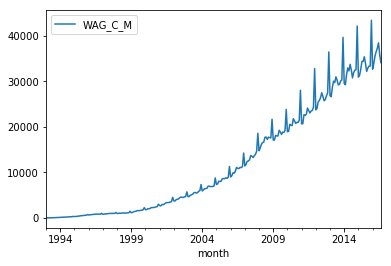

In [3]:
_ = data.plot()

### STL-декомпозиция

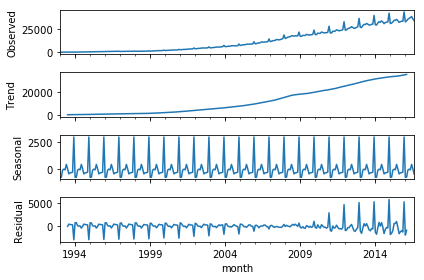

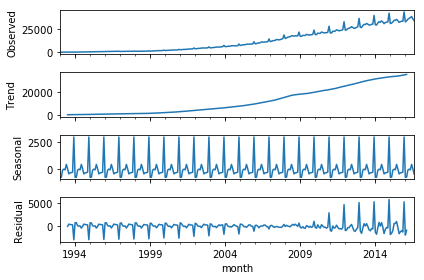

In [4]:
sm.tsa.seasonal_decompose(data).plot()

### Стабилизация дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


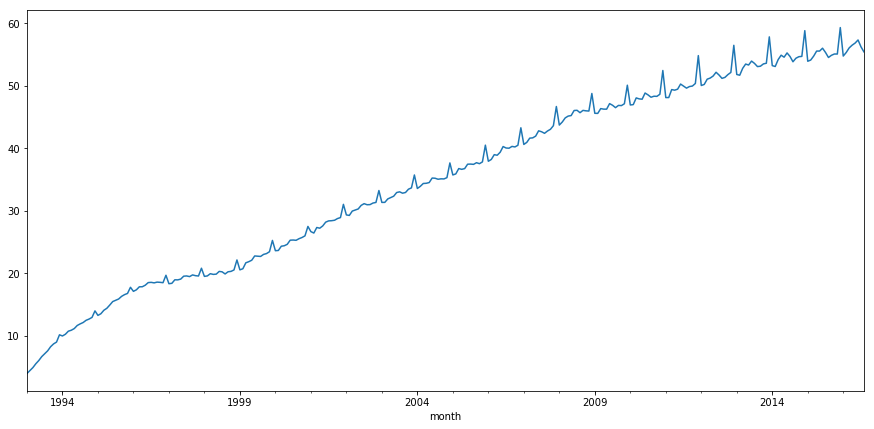

In [5]:
data['wag_c_m_box'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize(15,7))
data.wag_c_m_box.plot()
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wag_c_m_box)[1])

### Стационарность

Критерий Дики-Фуллера: p=0.014697


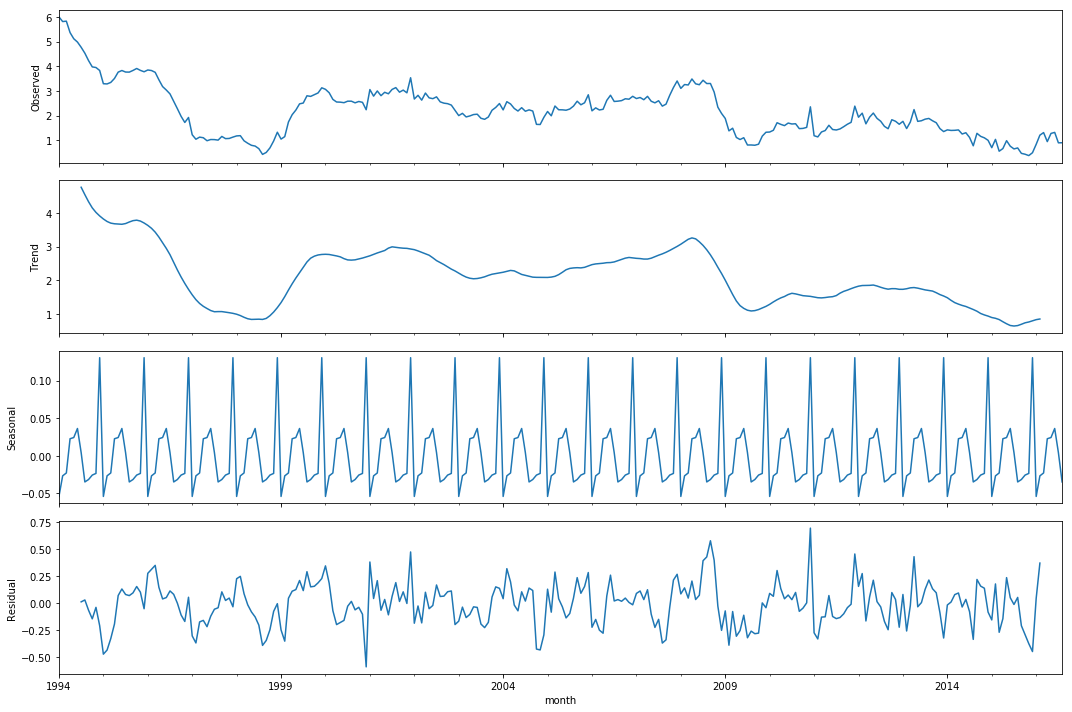

In [6]:
data['wag_c_m_box_diff_12'] = data.wag_c_m_box - data.wag_c_m_box.shift(12)

plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wag_c_m_box_diff_12[data.wag_c_m_box_diff_12.notnull()]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wag_c_m_box_diff_12[12:])[1])

Согласно критерию Дики-Фуллера мы не можем отвергнуть гипотезу нестационарности.
Так же мы может наблюдать отсутствие стационарности на ниже преведенном графике.

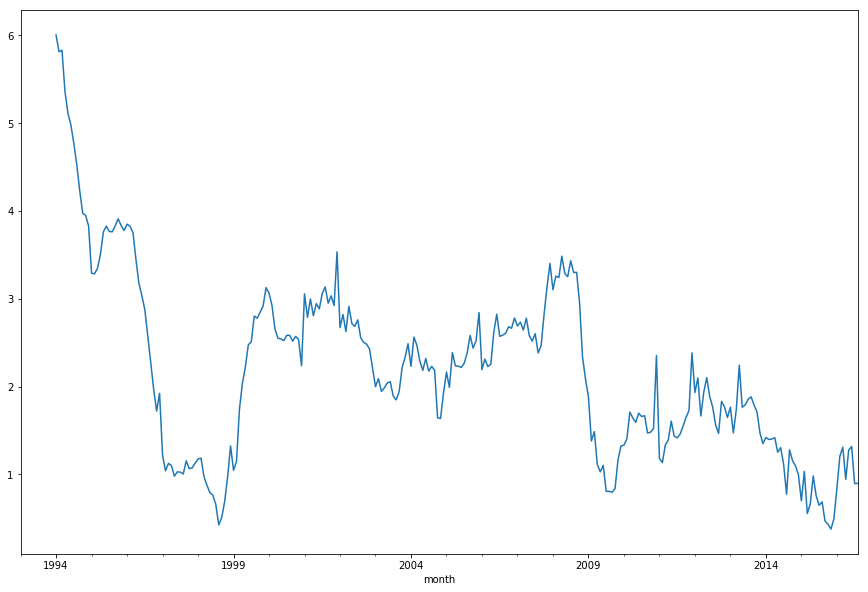

In [7]:
data['wag_c_m_box_diff_12'].plot()

Критерий Дики-Фуллера: p=0.000001


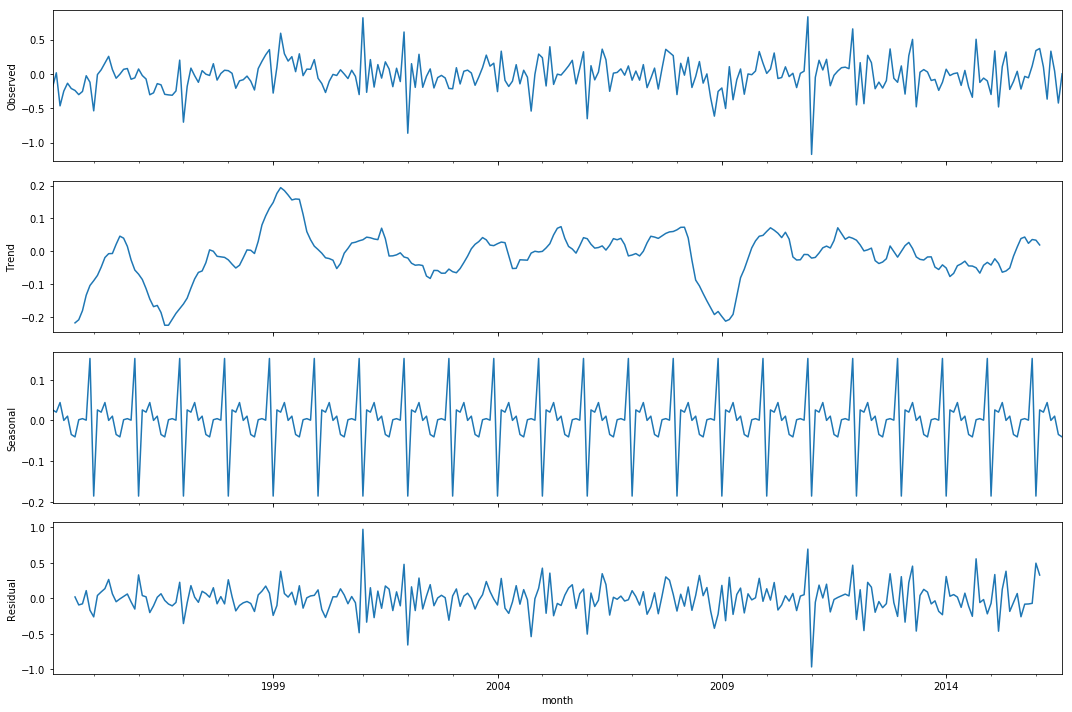

In [8]:
data['wag_c_m_box_diff_1'] = data.wag_c_m_box_diff_12 - data.wag_c_m_box_diff_12.shift(1)
    
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wag_c_m_box_diff_1[data.wag_c_m_box_diff_1.notnull()]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wag_c_m_box_diff_1.dropna()[12:])[1])

Теперь мы может отклонить гипотезу о нестационарности и так же наблюдать отсутствие тренда на графике ниже.

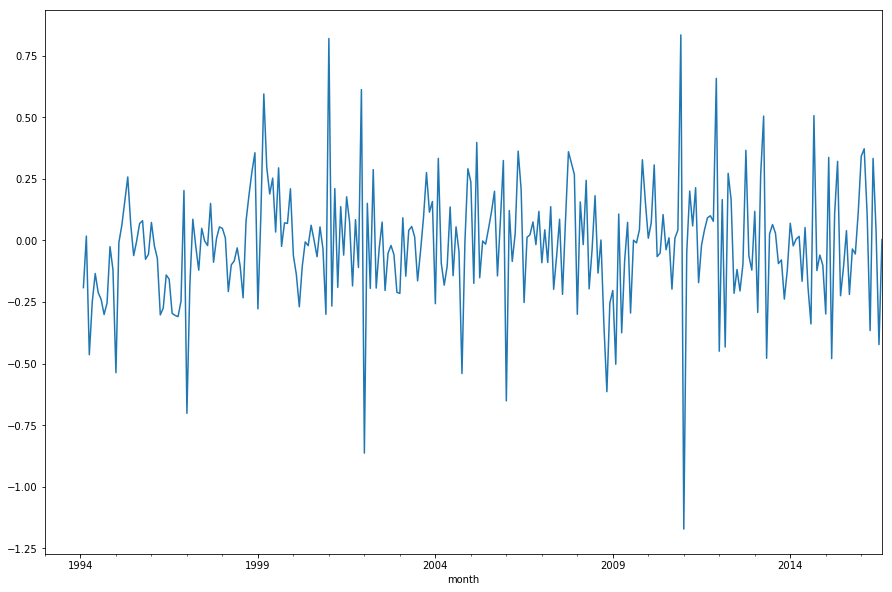

In [9]:
data['wag_c_m_box_diff_1'].plot()

### Подбор модели

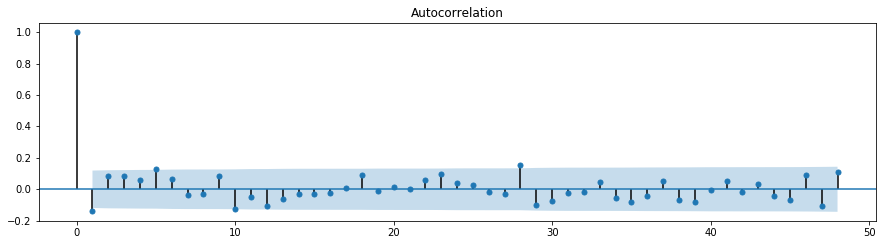

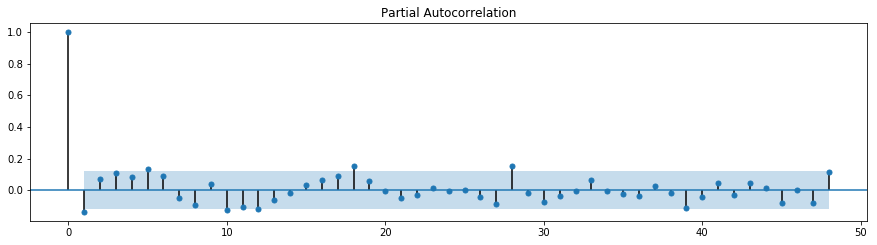

In [10]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.wag_c_m_box_diff_1[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.wag_c_m_box_diff_1[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=0, q=5, P=1, p=5

In [11]:
ps = range(6)
qs = range(6)
Ps = range(2)
Qs = range(1)

d, D = 1, 1

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

72

In [12]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.wag_c_m_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except LinAlgError:
        print('wrong parameters:', param)
        continue
    except ValueError:
        print ('wrong parameters:', param)
        continue
        
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (1, 2, 0, 0)
wrong parameters: (1, 2, 1, 0)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 2, 0, 0)
wrong parameters: (2, 2, 1, 0)
wrong parameters: (2, 3, 0, 0)
wrong parameters: (2, 3, 1, 0)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (3, 3, 0, 0)
wrong parameters: (3, 3, 1, 0)
wrong parameters: (3, 4, 0, 0)
wrong parameters: (3, 4, 1, 0)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 2, 1, 0)
wrong parameters: (4, 3, 0, 0)
wrong parameters: (4, 3, 1, 0)
wrong parameters: (4, 4, 0, 0)
wrong parameters: (4, 4, 1, 0)
wrong parameters: (5, 2, 0, 0)
wrong parameters: (5, 2, 1, 0)
wrong parameters: (5, 3, 0, 0)
wrong parameters: (5, 3, 1, 0)
wrong parameters: (5, 4, 0, 0)
wrong parameters: (5, 4, 1, 0)


In [13]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
44  (5, 5, 1, 0) -25.959842
43  (5, 5, 0, 0) -22.679310
20  (1, 5, 1, 0) -15.867142
31  (3, 5, 0, 0) -14.845127
32  (3, 5, 1, 0) -14.791712


In [14]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        wag_c_m_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  24.980
Date:                            Thu, 03 Aug 2017   AIC                            -25.960
Time:                                    23:28:05   BIC                             17.828
Sample:                                01-01-1993   HQIC                            -8.404
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0265      9.428      0.003      0.998     -18.452      18.505
ar.L2          0.0080      6.400   

#### Oстатки

Критерий Стьюдента: p=0.169574
Критерий Дики-Фуллера: p=0.000000


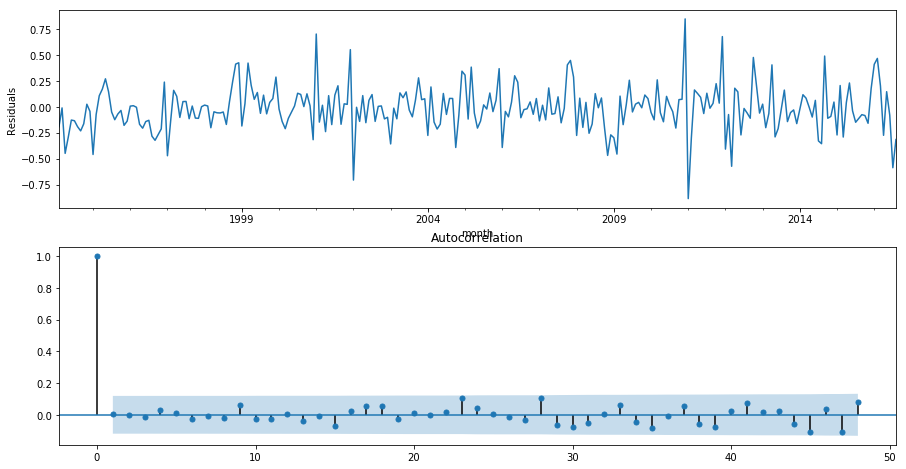

In [15]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

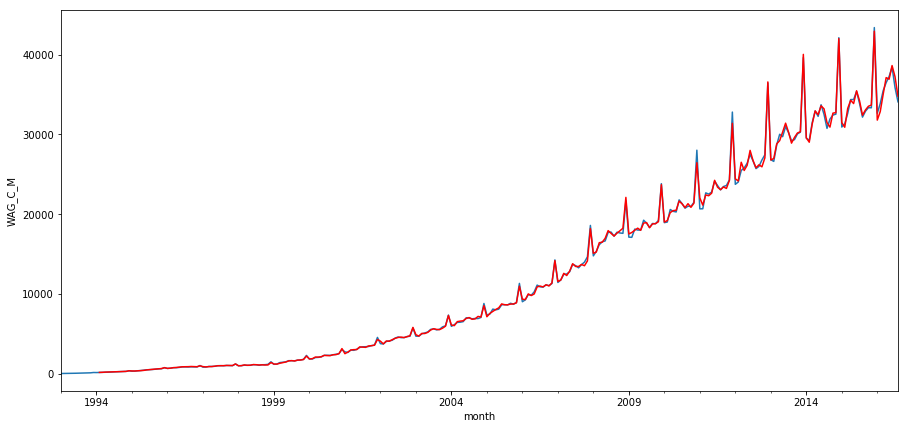

In [16]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel('WAG_C_M')
pylab.show()

### Прогноз

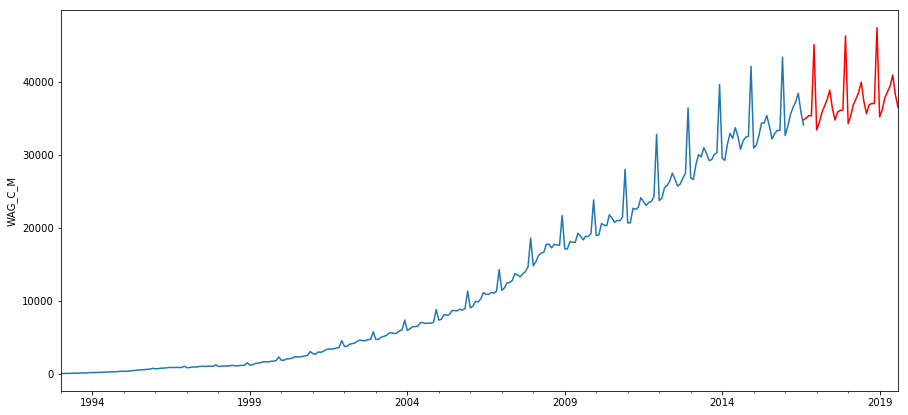

In [17]:
temp_data = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= temp_data.columns)
temp_data = pd.concat([temp_data, future])
temp_data['forecast'] = invboxcox(best_model.predict(start=283, end=333), lmbda)

plt.figure(figsize(15,7))
temp_data.WAG_C_M.plot()
temp_data.forecast.plot(color='r')
plt.ylabel('WAG_C_M')
pylab.show()